#### Applied Machine Learning and Data Engineering in Business Context

Final Project

December 1, 2021

### Steel Plate Fault Detection

Alisa Ilina		
Anurag Singh	
Eirik Egge		
Henry Stoll		
Magnus Eliassen	
Olivia Lundholm

# Data Ingestion

In [0]:
# imports 
from functools import reduce
from collections import Counter

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

import pyspark.sql.functions as f
from pyspark.sql.types import *
from pyspark.ml.feature import StringIndexer

#!pip install imblearn
#from imblearn.over_sampling import ADASYN
from sklearn.preprocessing import LabelEncoder

## Load Data

In [0]:
# load data
path = "/FileStore/tables/column.csv"
col = spark.read.csv(path, inferSchema=True, header=True, sep=";")

data_path = "/FileStore/tables/data.csv"
data_df = spark.read.csv(data_path, inferSchema=True, header=False, sep="\t")

target_columns = ["Pastry", "Z_Scratch", "K_Scatch", "Stains", "Dirtiness", "Bumps", "Other_Faults"]

df = data_df.toDF(*col.columns)

df = df.withColumn("id", f.monotonically_increasing_id())
df

display(df)

In [0]:
import os
os.listdir("/FileStore/tables/data.csv")

--------------------------------------------------------------------------- 
 FileNotFoundError Traceback (most recent call last)
 <command-4107286622685956> in <module> 
 1 import os
 ----> 2 os . listdir ( "/FileStore/tables/data.csv" ) 

 FileNotFoundError : [Errno 2] No such file or directory: '/FileStore/tables/data.csv'

In [0]:
#data_path = "/FileStore/tables/data.csv"
#data_df = spark.read.csv(data_path, inferSchema=True, header=False, sep="\t")
#df1 = spark.read.format('delta').load('/tmp/delta/data')

#people = spark.read.format('delta').load('/tmp/delta/data_csv_')

#display(people)

--------------------------------------------------------------------------- 
 AnalysisException Traceback (most recent call last)
 <command-4107286622685955> in <module> 
 3 #df1 = spark.read.format('delta').load('/tmp/delta/data') 
 4 
 ----> 5 people = spark . read . format ( 'delta' ) . load ( '/tmp/delta/data_csv_' ) 
 6 
 7 display ( people ) 

 /databricks/spark/python/pyspark/sql/readwriter.py in load (self, path, format, schema, **options) 
 202 self . options ( ** options ) 
 203 if isinstance ( path , str ) : 
 --> 204 return self . _df ( self . _jreader . load ( path ) ) 
 205 elif path is not None : 
 206 if type ( path ) != list : 

 /databricks/spark/python/lib/py4j-0.10.9-src.zip/py4j/java_gateway.py in __call__ (self, *args) 
 1302 
 1303 answer = self . gateway_client . send_command ( command ) 
 -> 1304 return_value = get_return_value(
 1305 answer, self.gateway_client, self.target_id, self.name)
 1306 

 /databricks/spark/python/pyspark/sql/utils.py in deco (*a, **kw) 
 121 # Hide where the exception came from that shows a non-Pythonic 
 122 # JVM exception message. 
 --> 123 raise converted from None 
 124 else : 
 125 raise 

 AnalysisException : `/tmp/delta/data_csv_` is not a Delta table.

In [0]:
#df = df.filter(df.label != 'other')

In [0]:
print('Overview of Schema')
df.printSchema()

Overview of Schema
root
-- X_Minimum: integer (nullable = true)
-- X_Maximum: integer (nullable = true)
-- Y_Minimum: integer (nullable = true)
-- Y_Maximum: integer (nullable = true)
-- Pixels_Areas: integer (nullable = true)
-- X_Perimeter: integer (nullable = true)
-- Y_Perimeter: integer (nullable = true)
-- Sum_of_Luminosity: integer (nullable = true)
-- Minimum_of_Luminosity: integer (nullable = true)
-- Maximum_of_Luminosity: integer (nullable = true)
-- Length_of_Conveyer: integer (nullable = true)
-- TypeOfSteel_A300: integer (nullable = true)
-- TypeOfSteel_A400: integer (nullable = true)
-- Steel_Plate_Thickness: integer (nullable = true)
-- Edges_Index: double (nullable = true)
-- Empty_Index: double (nullable = true)
-- Square_Index: double (nullable = true)
-- Outside_X_Index: double (nullable = true)
-- Edges_X_Index: double (nullable = true)
-- Edges_Y_Index: double (nullable = true)
-- Outside_Global_Index: double (nullable = true)
-- LogOfAreas: double (nullable = true)
-- Log_X_Index: double (nullable = true)
-- Log_Y_Index: double (nullable = true)
-- Orientation_Index: double (nullable = true)
-- Luminosity_Index: double (nullable = true)
-- SigmoidOfAreas: double (nullable = true)
-- Pastry: integer (nullable = true)
-- Z_Scratch: integer (nullable = true)
-- K_Scatch: integer (nullable = true)
-- Stains: integer (nullable = true)
-- Dirtiness: integer (nullable = true)
-- Bumps: integer (nullable = true)
-- Other_Faults: integer (nullable = true)
-- id: long (nullable = false)

## Check for NaN

In [0]:
# Check for NaN
from pyspark.sql.functions import isnan, when, count, col

na = df.select([count(when(isnan(c), c)).alias(c) for c in df.columns])
na = na.toPandas().transpose()
assert na.sum().sum() == 0
#na

In [0]:
def get_col_name(*cols):
#   return np.argmax(cols)
  return target_columns[np.argmax(cols)]

#convert to a UDF Function by passing in the function and return type of function
get_col_name_udf = f.udf(get_col_name, StringType())

df = df.withColumn("labels", get_col_name_udf(*target_columns))
display(df)

--------------------------------------------------------------------------- 
 NameError Traceback (most recent call last)
 <command-349352039010549> in <module> 
 4 
 5 #convert to a UDF Function by passing in the function and return type of function 
 ----> 6 get_col_name_udf = f . udf ( get_col_name , StringType ( ) ) 
 7 
 8 df = df . withColumn ( "labels" , get_col_name_udf ( * target_columns ) ) 

 NameError : name 'f' is not defined

In [0]:
display(df)

'Other_Faults', 'Bumps', 'K_Scratch', 'Z_Scratch', 'Pastry', 'Stains', 'Dirtiness'

In [0]:
df_pandas = df.toPandas()

In [0]:
fig = go.Figure()
fig.add_trace(go.Bar(
    x=['Other_Faults'],
    y=[673],
    name='Other Faults',
    marker_color = '#d9d9d9',
    text = '35%'
))

fig.add_trace(go.Bar(
    x=['Bumps', 'K_Scratch', 'Z_Scratch', 'Pastry', 'Stains', 'Dirtiness'],
    y=[402, 391, 190, 158, 72, 55],
    name='Common Faults',
    marker_color = '#3394ba', 
    text = ['21%', '20%', '10%', '8%', '4%', '3%']
))

fig.update_layout(title_text='Frequency of Fault Types', plot_bgcolor='#FFF')

fig.show()

## Boxplot

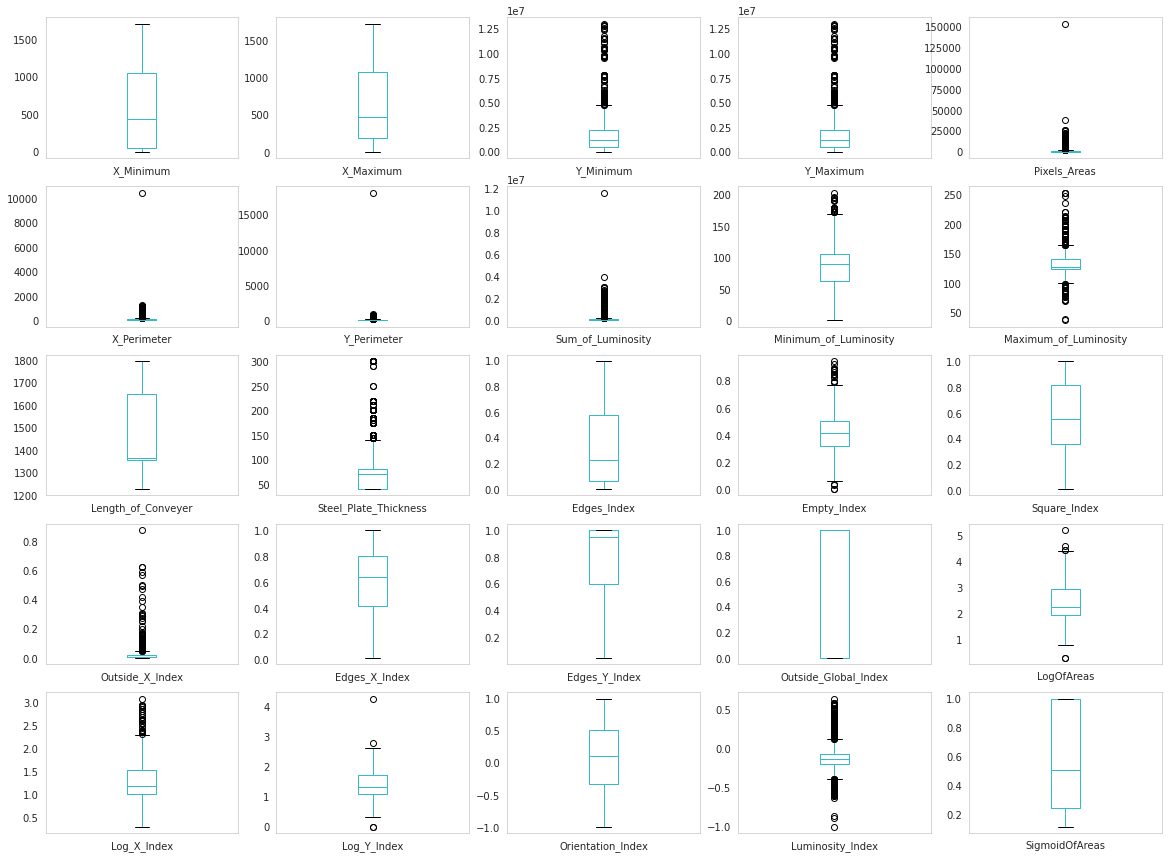

In [0]:
# check for outliers
# drop categorical features and plot
df_pandas.iloc[:, : 27].drop(['TypeOfSteel_A300', 'TypeOfSteel_A400'], axis =1).plot(kind='box', layout=(5,5), 
            subplots=True,
            figsize=(20,15) )
plt.show()

## Outlier Removal

In [0]:
outlier_columns = ['Pixels_Areas', 'X_Perimeter', 'Y_Perimeter', 'Sum_of_Luminosity', 'Outside_X_Index', 'Log_Y_Index'] 

def remove_outlier(df, col_names: list):
  before = df.count()
  for col_name in col_names:
    print(f"before removing {col_name} there are {df.count()}")
    q1, q3 = df.approxQuantile(col_name, [0.05, 0.95], 0)
    iqr = q3 - q1
    min_val = q1 - (iqr * 1.5)
    max_val = q3 + (iqr * 1.5)
    df = df.filter(f"{col_name} BETWEEN {min_val} AND {max_val}") 
  print(f"results {df.count()} rows with {before - df.count()} rows where removed")
  return df

df = remove_outlier(df, outlier_columns)

before removing Pixels_Areas there are 1941
before removing X_Perimeter there are 1939
before removing Y_Perimeter there are 1939
before removing Sum_of_Luminosity there are 1939
before removing Outside_X_Index there are 1939
before removing Log_Y_Index there are 1928
results 1928 rows with 13 rows where removed

##Oversampling

In [0]:
def clean_data(df_spark, label_column):
  df = df_spark.toPandas()
  df["label"] = df[label_column]
  return df.drop([label_column], axis=1)

def oversample_and_split_and_write_table(df, label_column="labels", table_name="multiclass") -> tuple:
  # spark df, do random split
  df = df.drop("id")
  
  df_train, df_test = [clean_data(df_spark, label_column) for df_spark in df.randomSplit([0.75, 0.25], seed=13)]

  X, y = df_train.drop(["label"], axis=1), df_train["label"]
  # prep data
  le = LabelEncoder()
  y = le.fit_transform(y)
  if table_name == "multiclass":
    df_test["label"] = le.transform(df_test["label"])
  
  X_new = X
  X_new["label"] = y
  df_train_non_oversampled = spark.createDataFrame(X_new)
  df_train_auto = df_train_non_oversampled.drop(*target_columns)
    
  print(le.classes_)
  # oversampling
  oversampler = ADASYN(n_jobs=128)
  X, y = oversampler.fit_resample(X, y)

  # display stats
  counter = Counter(y)
  plt.bar(counter.keys(), counter.values())
  plt.title(f"{table_name} classification classes")
  plt.show()

  # make new dataframe after oversampling
  X["label"] = y
  df_train = spark.createDataFrame(X)
  df_test = spark.createDataFrame(df_test)
  
  
  # write to permanent table
  permanent_table_name = "steel_faults_oversampled"
  other_name = "steel_faults_non_oversampled"
  
  df_train.write.format("parquet").mode("overwrite").saveAsTable(f"{permanent_table_name}_{table_name}_train")
  df_test.write.format("parquet").mode("overwrite").saveAsTable(f"{permanent_table_name}_{table_name}_test")
  df_train_non_oversampled.write.format("parquet").mode("overwrite").saveAsTable(f"{other_name}_{table_name}_train")
  df_train_auto.write.format("parquet").mode("overwrite").saveAsTable(f"steel_faults_automl_{table_name}_train")
  
  # both are spark dfs
  return df_train, df_test
    

df_b_train, df_b_test = oversample_and_split_and_write_table(df.drop("labels"), label_column="Other_Faults", table_name="binary")
df_mc_train, df_mc_test = oversample_and_split_and_write_table(df)

In [0]:
print((df_b_train.count(), len(df_b_train.columns)))
print((df_b_test.count(), len(df_b_test.columns)))
print((df_mc_train.count(), len(df_mc_train.columns)))
print((df_mc_test.count(), len(df_mc_test.columns)))